# Introducción

Kaggle describe esta competición de la siguiente manera:

Millones de animales callejeros sufren en las calles o son sacrificados en refugios cada día en todo el mundo. Si se les encuentra un hogar, se salvarán muchas vidas preciosas y se crearán más familias felices.

PetFinder.my es la principal plataforma de bienestar animal de Malasia desde 2008, con una base de datos de más de 150.000 animales. PetFinder colabora estrechamente con amantes de los animales, medios de comunicación, empresas y organizaciones mundiales para mejorar el bienestar animal.

En este concurso se desarrollarán algoritmos para predecir la adoptabilidad de las mascotas, en concreto, con qué rapidez se adopta una mascota. 


# The target variable: Adoption Speed¶
Los concursantes deben predecir este valor. El valor viene determinado por la rapidez con la que se adopta una mascota, si es que se adopta. Los valores se determinan de la siguiente manera:

        - **0** - La mascota fue adoptada el mismo día que se incluyó en la lista.
        - **1** - La mascota fue adoptada entre 1 y 7 días (1ª semana) después de ser incluida en la lista.
        - **2** - La mascota fue adoptada entre 8 y 30 días (1er mes) después de ser incluida en la lista.
        - **3** - La mascota fue adoptada entre 31 y 90 días (2º y 3er mes) después de su inclusión en la lista.
        - **4** - Ninguna adopción después de 100 días de estar en la lista.

# Variables
| Variable        | Descripción                                                                 |
|----------------|------------------------------------------------------------------------------|
| PetID          | Identificador único encriptado del perfil de la mascota.                    |
| AdoptionSpeed  | Velocidad categórica de adopción. Cuanto menor es el número, más rápida fue la adopción. Este es el valor que se debe predecir. |
| Type           | Tipo de animal (1 = Perro, 2 = Gato).                                       |
| Name           | Nombre de la mascota (vacío si no tiene nombre).                            |
| Age            | Edad de la mascota al momento de ser listada, en meses.                     |
| Breed1         | Raza principal de la mascota (consultar el diccionario de etiquetas de razas). |
| Breed2         | Raza secundaria, si la mascota es mestiza (consultar el diccionario de etiquetas de razas). |
| Gender         | Sexo de la mascota (1 = Macho, 2 = Hembra, 3 = Mixto, si el perfil representa un grupo de mascotas). |
| Color1         | Primer color de la mascota (consultar el diccionario de etiquetas de colores). |
| Color2         | Segundo color de la mascota (consultar el diccionario de etiquetas de colores). |
| Color3         | Tercer color de la mascota (consultar el diccionario de etiquetas de colores). |
| MaturitySize   | Tamaño de la mascota cuando alcance la madurez (1 = Pequeño, 2 = Mediano, 3 = Grande, 4 = Extra grande, 0 = No especificado). |
| FurLength      | Longitud del pelaje (1 = Corto, 2 = Medio, 3 = Largo, 0 = No especificado). |
| Vaccinated     | Indica si la mascota ha sido vacunada (1 = Sí, 2 = No, 3 = No está claro).  |
| Dewormed       | Indica si la mascota ha sido desparasitada (1 = Sí, 2 = No, 3 = No está claro). |
| Sterilized     | Indica si la mascota ha sido esterilizada o castrada (1 = Sí, 2 = No, 3 = No está claro). |
| Health         | Estado de salud (1 = Saludable, 2 = Lesión menor, 3 = Lesión grave, 0 = No especificado). |
| Quantity       | Número de mascotas representadas en el perfil.                              |
| Fee            | Tarifa de adopción (0 = Gratuita).                                          |
| State          | Estado (provincia) de ubicación en Malasia (consultar el diccionario de etiquetas de estados). |
| RescuerID      | Identificador único encriptado de la persona rescatista.                    |
| VideoAmt       | Cantidad total de videos subidos para esta mascota.                         |
| PhotoAmt       | Cantidad total de fotos subidas para esta mascota.                          |
| Description    | Descripción del perfil de la mascota. El idioma principal es inglés, aunque también puede haber partes en malayo o chino. |


# Ingesta de Datos

In [21]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
from wordcloud import WordCloud

In [22]:
print(os.listdir("./input/petfinder-adoption-prediction"))

['test_images', 'breed_labels.csv', '.DS_Store', 'test', 'train_metadata', 'color_labels.csv', 'test_sentiment', 'test_metadata', 'StateLabels.csv', 'ColorLabels.csv', 'PetFinder-BreedLabels.csv', 'train_sentiment', 'train', 'BreedLabels.csv', 'PetFinder-ColorLabels.csv', 'train_images', 'PetFinder-StateLabels.csv', 'state_labels.csv']


In [53]:
train_dtypes = {
        'PetID':                            'str',
        'AdoptionSpeed ':                   'int8',
        'Type':                             'int',
        'Name':                             'str',
        'Age':                              'int8',
        'Breed1':                           'category',
        'Breed2':                           'category',
        'Gender':                           'category',
        'Color1':                           'category',
        'Color2':                           'category',
        'Color3':                           'category',
        'MaturitySize':                     'float16',
        'FurLength':                        'int8',
        'Vaccinated':                       'category',
        'Dewormed':                         'category',
        'Sterilized':                       'category',
        'Health':                           'category',
        'Quantity':                         'uint16',
        'State':                            'category',
        'Fee':                              'float',
        'RescuerID':                        'category',
        'VideoAmt':                         'uint16',
        'PhotoAmt':                         'uint16',
        'Description ':                     'str'
        }

breeds_dtypes = {
        'BreedID':                          'category',
        'Type ':                            'category',
        'BreedName':                        'str'
        }

colors_dtypes = {
        'ColorID':                          'category',
        'ColorName':                        'str'
        }

states_dtypes = {
        'StateID':                          'category',
        'StateName':                        'str'
        }

In [54]:
main_path = './input/petfinder-adoption-prediction/'

In [85]:
breeds = pd.read_csv(f'{main_path}breed_labels.csv', dtype=breeds_dtypes)
colors = pd.read_csv(f'{main_path}color_labels.csv',  dtype=colors_dtypes)
states = pd.read_csv('./input/petfinder-adoption-prediction/state_labels.csv', dtype=states_dtypes)

train = pd.read_csv(f'{main_path}train/train.csv', dtype=train_dtypes)

df = train.copy()

# Exploracion del Dataset

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Type           14993 non-null  int64   
 1   Name           13728 non-null  object  
 2   Age            14993 non-null  int8    
 3   Breed1         14993 non-null  category
 4   Breed2         14993 non-null  category
 5   Gender         14993 non-null  category
 6   Color1         14993 non-null  category
 7   Color2         14993 non-null  category
 8   Color3         14993 non-null  category
 9   MaturitySize   14993 non-null  float16 
 10  FurLength      14993 non-null  int8    
 11  Vaccinated     14993 non-null  category
 12  Dewormed       14993 non-null  category
 13  Sterilized     14993 non-null  category
 14  Health         14993 non-null  category
 15  Quantity       14993 non-null  uint16  
 16  Fee            14993 non-null  float64 
 17  State          14993 non-null  

In [88]:
df.sample(10).T

,10403,11081,7873,14477,11337,4673,4642,5565,12558,2139
Type,2,1,1,2,2,1,1,2,2,2
Name,Orange Panther - Indoor Companion,Ah Girl,Monica,Dubu,1 Kitten,Jinny & Jenny,Mama,Mickey,Velvet,Mugee
Age,24,15,2,6,3,2,36,1,3,12
Breed1,266,179,307,265,266,72,141,266,264,303
Breed2,0,179,0,0,266,141,307,0,0,0
Gender,1,2,2,1,1,2,2,1,2,2
Color1,4,5,2,3,1,2,1,1,2,1
Color2,7,0,0,0,2,0,0,2,6,2
Color3,0,0,0,0,0,0,0,7,0,4
MaturitySize,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0


In [89]:
df.shape

(14993, 24)

In [90]:
# Diccionarios de mapeo basados en tu descripción
map_type = {1: 'Perro', 2: 'Gato'}
map_gender = {1: 'Macho', 2: 'Hembra', 3: 'Mixto'}
map_maturity = {1: 'Pequeño', 2: 'Mediano', 3: 'Grande', 4: 'Extra grande', 0: 'No especificado'}
map_furlength = {1: 'Corto', 2: 'Medio', 3: 'Largo', 0: 'No especificado'}
map_vaccinated = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_dewormed = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_sterilized = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_health = {1: 'Saludable', 2: 'Lesión menor', 3: 'Lesión grave', 0: 'No especificado'}
map_adoption_speed = {
    0: "mismo día",
    1: "1-7 días",
    2: "8-30 días",
    3: "31-90 días",
    4: "(90+ días)"
}


In [91]:
# Copiamos el DataFrame original
df_expl = df.copy()

In [92]:
# Aplicamos los mapeos a las columnas codificadas
df_expl['Type'] = df_expl['Type'].astype('int').map(map_type)
df_expl['Gender'] = df_expl['Gender'].astype('int').map(map_gender)
df_expl['MaturitySize'] = df_expl['MaturitySize'].astype('int').map(map_maturity)
df_expl['FurLength'] = df_expl['FurLength'].astype('int').map(map_furlength)
df_expl['Vaccinated'] = df_expl['Vaccinated'].astype('int').map(map_vaccinated)
df_expl['Dewormed'] = df_expl['Dewormed'].astype('int').map(map_dewormed)
df_expl['Sterilized'] = df_expl['Sterilized'].astype('int').map(map_sterilized)
df_expl['Health'] = df_expl['Health'].astype('int').map(map_health)
df_expl['AdoptionSpeed'] = df_expl['AdoptionSpeed'].astype('int').map(map_adoption_speed)


In [93]:
df_expl.sample(10).T

,11866,7588,838,6880,5793,2899,3177,11357,11896,11899
Type,Perro,Perro,Gato,Gato,Perro,Perro,Gato,Perro,Gato,Perro
Name,Jojo,NaN,Grey & Black,Coco,Coco,Hei Bing,"Tina, Jaylyn & Noah",Four Month Female Shih Tzu,Missy,Macy
Age,2,2,2,24,8,24,2,4,5,6
Breed1,307,307,265,265,307,218,266,205,266,307
Breed2,307,0,0,0,0,307,0,0,0,0
Gender,Hembra,Hembra,Mixto,Mixto,Hembra,Macho,Mixto,Hembra,Hembra,Hembra
Color1,2,5,1,1,2,1,1,1,1,5
Color2,0,0,6,2,7,0,2,2,3,7
Color3,0,0,7,0,0,0,3,7,7,0
MaturitySize,Pequeño,Mediano,Pequeño,Pequeño,Mediano,Mediano,Mediano,Pequeño,Mediano,Mediano


Distribucion de la variable target

In [95]:
df_expl['AdoptionSpeed'].value_counts().to_frame('Cantidad').assign(Porcentaje=lambda x: x/x.sum()*100)

,Cantidad,Porcentaje
AdoptionSpeed,,
(90+ días),4197,27.993063
8-30 días,4037,26.925899
31-90 días,3259,21.736811
1-7 días,3090,20.609618
mismo día,410,2.734609


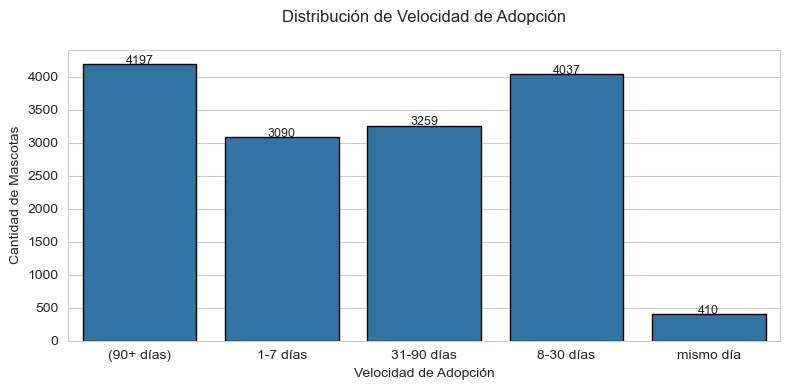

In [96]:
# Preparar datos
adoption_counts = df_expl['AdoptionSpeed'].value_counts().sort_index().reset_index()
adoption_counts.columns = ['AdoptionSpeed', 'count']


# Crear gráfico
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=adoption_counts,
    x='AdoptionSpeed',
    y='count',
    #palette=colors,
    edgecolor='black'
)

# Etiquetas y título
plt.title('Distribución de Velocidad de Adopción', pad=20)
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad de Mascotas')

# Etiquetas sobre las barras
for i, row in adoption_counts.iterrows():
    ax.text(i, row['count'] + 2, row['count'], ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [99]:
df_expl.sample(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
463,NaN,KFC,3,266,0,Macho,4,0,0,Pequeño,...,Saludable,1,0.0,41401,7e8f6dedd6abd887a6932c6877a5c001,0,Rescued and Vaccinated/ Dewormed. Healthy cute...,75a4a14ac,6,8-30 días
10015,NaN,NaN,1,307,0,Mixto,1,2,0,Pequeño,...,Saludable,4,0.0,41326,0b77dc457c1efd0d80a195ee91a6cfc6,0,"Well this Puppies are for adoption, Looking fo...",f5819a31d,1,31-90 días


<Figure size 1200x600 with 0 Axes>

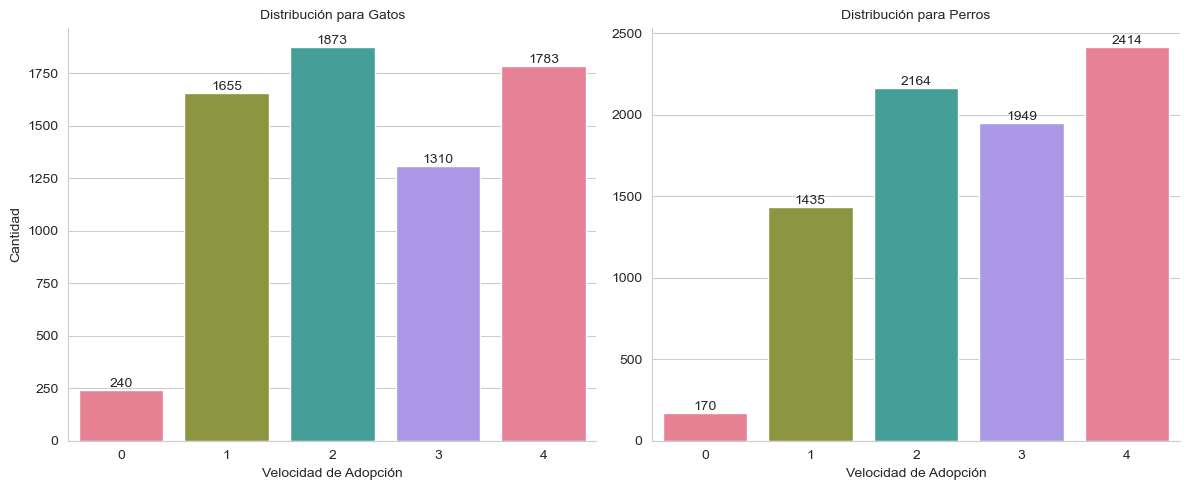

In [64]:
# Preparar los datos
plot_data = df[df['Type'].isin(['Perros', 'Gatos'])].copy()
#plot_data['Type'] = plot_data['Type'].map({1: 'Perros', 2: 'Gatos'})

# Configuración
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Crear el gráfico
g = sns.FacetGrid(plot_data, col='Type', height=5, aspect=1.2, sharey=False)
g.map_dataframe(
    sns.countplot,
    x='AdoptionSpeed',
    hue='AdoptionSpeed',  # Soluciona el warning de palette
    palette='husl',
    order=sorted(plot_data['AdoptionSpeed'].unique()),
    legend=False  # Evita que muestre la leyenda de hue
)

# Configurar títulos y etiquetas
g.set_axis_labels('Velocidad de Adopción', 'Cantidad')
g.set_titles(col_template='Distribución para {col_name}')  # Corrige el KeyError

# Añadir los valores en las barras
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

In [65]:
# Contar las ocurrencias de cada combinación
conteo = df.groupby(['AdoptionSpeed', 'Type']).size().reset_index(name='Conteo')

In [66]:
conteo

,AdoptionSpeed,Type,Conteo
0,0,Gatos,240
1,0,Perros,170
2,1,Gatos,1655
3,1,Perros,1435
4,2,Gatos,1873
5,2,Perros,2164
6,3,Gatos,1310
7,3,Perros,1949
8,4,Gatos,1783
9,4,Perros,2414


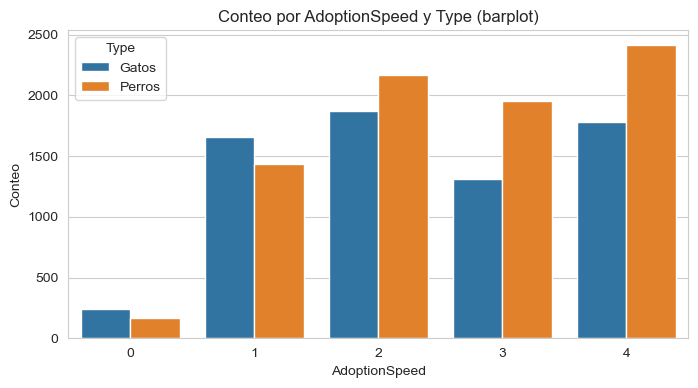

In [67]:
# Método 2: Usando barplot con los datos pre-agrupados
plt.figure(figsize=(8, 4))
sns.barplot(x='AdoptionSpeed', y='Conteo', hue='Type', data=conteo)
plt.title('Conteo por AdoptionSpeed y Type (barplot)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Type')
plt.show()

In [68]:
df['Type'].value_counts().to_frame('Cantidad').assign(Porcentaje=lambda x: x/x.sum()*100)

,Cantidad,Porcentaje
Type,,
Perros,8132,54.238645
Gatos,6861,45.761355


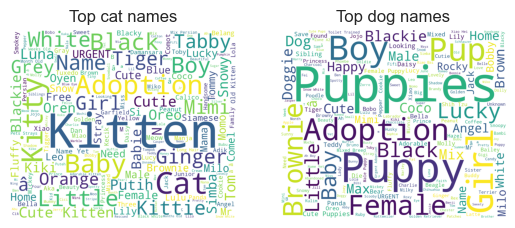

In [70]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(df.loc[df['Type'] == 'Gatos', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(df.loc[df['Type'] == 'Perros', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

# Uniones con informacion relevante

In [73]:
# Unificamos la información de razas (Breed1 y Breed2)
breeds = breeds.rename(columns={"BreedID": "Breed1"})

# Merge para Breed1
df = pd.merge(df, breeds[["Breed1", "BreedName"]], how="left", on="Breed1")
df = df.rename(columns={"BreedName": "BreedName_1"})

# Preparación y merge para Breed2
breeds = breeds.rename(columns={"Breed1": "Breed2"})  # reutilizamos el DataFrame cambiando la columna
df = pd.merge(df, breeds[["Breed2", "BreedName"]], how="left", on="Breed2")
df = df.rename(columns={"BreedName": "BreedName_2"})


# Unificamos la información de colores (Color1, Color2, Color3)
colors = colors.rename(columns={"ColorID": "Color1"})

# Merge para Color1
df = pd.merge(df, colors[["Color1", "ColorName"]], how="left", on="Color1")
df = df.rename(columns={"ColorName": "ColorName_1"})

# Preparación y merge para Color2
colors = colors.rename(columns={"Color1": "Color2"})
df = pd.merge(df, colors[["Color2", "ColorName"]], how="left", on="Color2")
df = df.rename(columns={"ColorName": "ColorName_2"})

# Preparación y merge para Color3
colors = colors.rename(columns={"Color2": "Color3"})
df = pd.merge(df, colors[["Color3", "ColorName"]], how="left", on="Color3")
df = df.rename(columns={"ColorName": "ColorName_3"})


# Unificamos la información de estados
states = states.rename(columns={"StateID": "State"})
df = pd.merge(df, states[["State", "StateName"]], how="left", on="State")

# Visualización rápida del resultado
df.head(4)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Description,PetID,PhotoAmt,AdoptionSpeed,BreedName_1,BreedName_2,ColorName_1,ColorName_2,ColorName_3,StateName
0,Gatos,Nibble,3,299,0,1,1,7,0,1.0,...,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2,Tabby,NaN,Black,White,NaN,Selangor
1,Gatos,No Name Yet,1,265,0,1,1,2,0,2.0,...,I just found it alone yesterday near my apartm...,6296e909a,2,0,Domestic Medium Hair,NaN,Black,Brown,NaN,Kuala Lumpur
2,Perros,Brisco,1,307,0,1,2,7,0,2.0,...,Their pregnant mother was dumped by her irresp...,3422e4906,7,3,Mixed Breed,NaN,Brown,White,NaN,Selangor
3,Perros,Miko,4,307,0,2,1,2,0,2.0,...,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2,Mixed Breed,NaN,Black,Brown,NaN,Kuala Lumpur


In [75]:
df.sample(5).T

,1781,8526,2234,2589,4014
Type,Gatos,Perros,Perros,Gatos,Gatos
Name,Chichi,Vanilla,F6,Chichi's Kittens,Sarah
Age,14,2,1,2,1
Breed1,264,307,307,265,265
Breed2,265,117,307,266,0
Gender,2,2,2,3,2
Color1,3,3,1,1,1
Color2,5,5,2,4,5
Color3,7,0,0,7,7
MaturitySize,2.0,2.0,2.0,1.0,1.0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Type           14993 non-null  object  
 1   Name           13728 non-null  object  
 2   Age            14993 non-null  int8    
 3   Breed1         14993 non-null  object  
 4   Breed2         14993 non-null  object  
 5   Gender         14993 non-null  category
 6   Color1         14993 non-null  category
 7   Color2         14993 non-null  object  
 8   Color3         14993 non-null  object  
 9   MaturitySize   14993 non-null  float16 
 10  FurLength      14993 non-null  int8    
 11  Vaccinated     14993 non-null  category
 12  Dewormed       14993 non-null  category
 13  Sterilized     14993 non-null  category
 14  Health         14993 non-null  category
 15  Quantity       14993 non-null  uint16  
 16  Fee            14993 non-null  float64 
 17  State          14993 non-null  

In [80]:
def plot_categorical_distribution(df, column, target='AdoptionSpeed'):
    plt.figure(figsize=(8, 4))
    
    # Agrupar y calcular proporciones por categoría
    grouped = df.groupby([column, target]).size().reset_index(name='count')
    total_per_cat = grouped.groupby(column)['count'].transform('sum')
    grouped['Proportion'] = grouped['count'] / total_per_cat

    sns.barplot(data=grouped, x=column, y='Proportion', hue=target)
    plt.title(f'{column} vs {target}')
    plt.ylabel('Proporción por categoría')
    plt.legend(title=target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [82]:
# Aplicar a variables categóricas principales
categorical_cols = [
    "Gender", "Vaccinated", "Dewormed", "Sterilized",
    "Health", "FurLength"
]

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([column, target]).size().reset_index(name='count')
/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_cat = grouped.groupby(column)['count'].transform('sum')


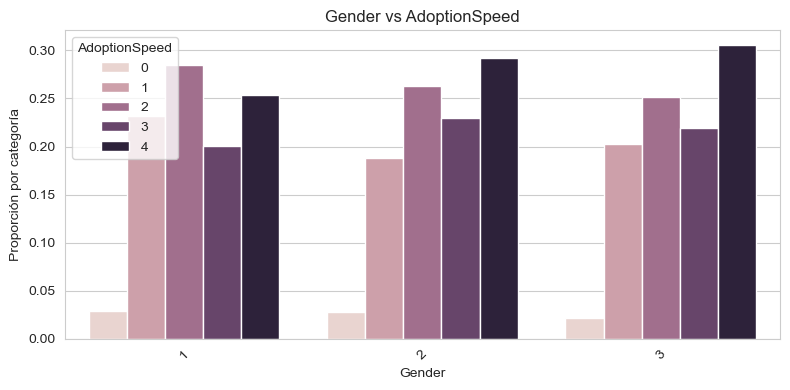

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([column, target]).size().reset_index(name='count')
/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_cat = grouped.groupby(column)['count'].transform('sum')


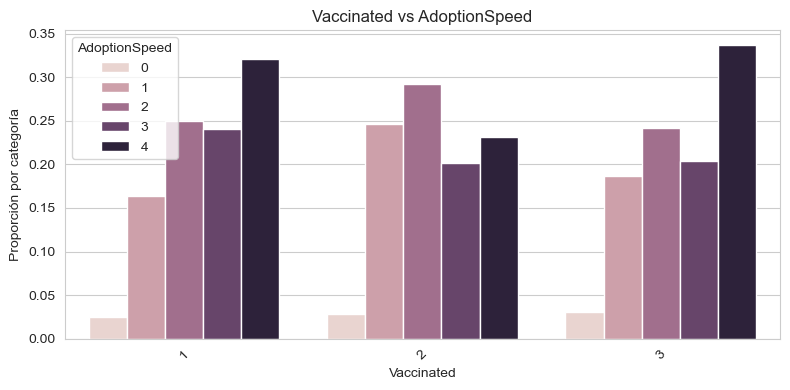

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([column, target]).size().reset_index(name='count')
/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_cat = grouped.groupby(column)['count'].transform('sum')


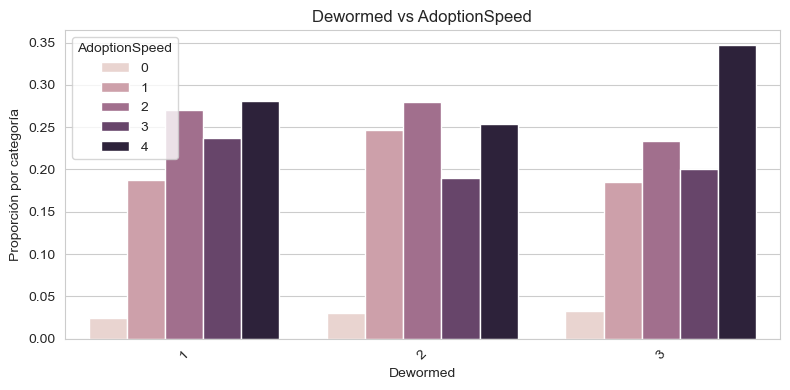

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([column, target]).size().reset_index(name='count')
/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_cat = grouped.groupby(column)['count'].transform('sum')


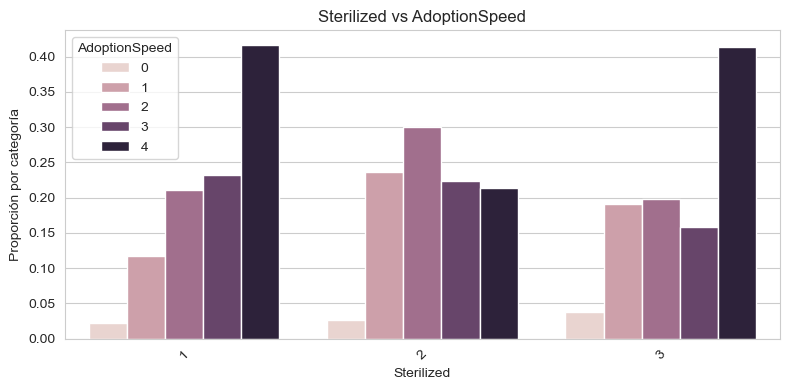

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([column, target]).size().reset_index(name='count')
/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2259580879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_cat = grouped.groupby(column)['count'].transform('sum')


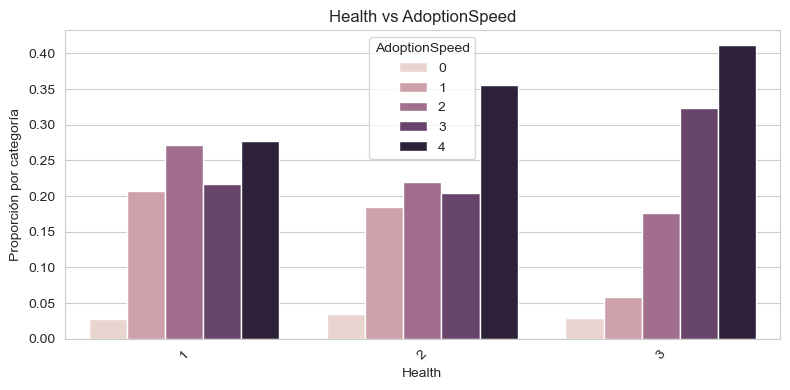

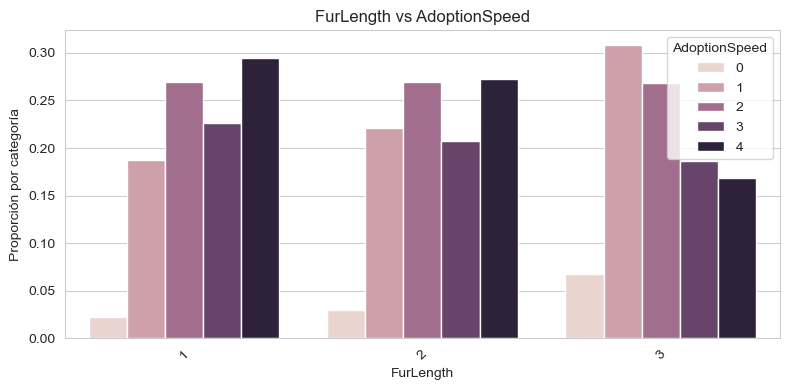

In [83]:
for col in categorical_cols:
    plot_categorical_distribution(df, col)
